### **3. Wrangle, prepare, cleanse the data**

In this section, we will prepare the data to ensure that the model operates optimally. We will follow a set of steps based on the analysis we conducted in Section 2 Data Analysis. The phases we will work on include:

**3.1 Cleaning:** Removing duplicates, correcting incorrect column names and removing irrelevant columns.\
**3.2 Integration:** Data grouping, handling missing values and changing data types\
**3.3 Construction:** Creating new features and encoding categorical features.\
**3.4 Feature selection:** Studying correlations and variance.

Libraries:

In [1]:
# Data analysis and wrangling
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OrdinalEncoder,StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

# Machine learning

Acquire data:

In [2]:
df = pd.read_csv('data_easymoney.csv')

#### **3.1 Cleaning**

##### **Removing duplicates**

We note that we do not have any duplicated rows.

In [3]:
df.duplicated().sum()

0

##### **Correcting incorrect column names**

We can see how the em_acount variable is misspelled, it should be em_account. Not correcting this error, no matter how insignificant it may seem now, can lead to problems later when working with this column. We proceed to correct the error:

In [4]:
df.columns

Index(['Unnamed: 0', 'pk_cid', 'pk_partition', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp',
       'credit_card', 'payroll', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount', 'entry_date',
       'entry_channel', 'active_customer', 'segment', 'country_id',
       'region_code', 'gender', 'age', 'deceased', 'salary'],
      dtype='object')

In [5]:
df.rename(columns = {"em_acount":"em_account"}, inplace = True)

##### **Removing inrrelevant columns**

Although later we will do correlation and variance studies, where we will delve into those columns that may be irrelevant, taking a quick look we can see that:

* 'Unnamed:0' : This column acts as an inndex of the rows of our sample. This column is obviusly irrelevant since the dataframe structure already has indexes.
* 'em_account_pp': All the values in the 'em_account_pp' column are 0`s. Obviously this column is irrelevant because it is not giving us any new information.

In [6]:
df['em_account_pp'].value_counts()

em_account_pp
0    5962924
Name: count, dtype: int64

In [7]:
df.drop(columns = ["Unnamed: 0", "em_account_pp"], axis = 1, inplace = True)

#### **3.2 Integration**

##### **Data grouping**

When we have many different values for the same feature, the models may not be as efficient. It is more optimal if instead of having many values for a single feature, we have fewer. We can create new values or group those less frequent values into one.
First of all let's see what features we can apply this procedure:

* **country_id:** ES (Spain) has 5,960,672 of the total registrations, that is a 99.96% of the total. We can separate the data into "Spain" and "Others."

In [8]:
df['country_id'].value_counts()

country_id
ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: count, dtype: int64

We add all the values that are not Spain in a list, and then we regroup all these values by the value "OTHERS". We finally see how the values of the "country_id" feature look.

In [9]:
others_country = df['country_id'].value_counts()[df['country_id'].value_counts() < 500 ].index.tolist()
df.loc[df['country_id'].isin(others_country), 'country_id'] = 'OTHERS'

In [10]:
df['country_id'].value_counts()

country_id
ES        5960672
OTHERS       2252
Name: count, dtype: int64

* **entry_channel:** To optimize the performance of the model it is advisable to regroup the variables. We will use the same criteria that we have used in Section 2 --> EDA, Analyze by visualizing data,  where we have visualized the entry_channel variable regrouping those values that have a frequency less than 2% of the total values.

We see how we have too many values for a single feature.

In [11]:
df['entry_channel'].value_counts()

entry_channel
KHE    3113947
KFC     890620
KHQ     590280
KAT     416084
KHK     230197
        ...   
KEJ          8
KHS          5
KDA          2
KFP          2
KDS          1
Name: count, Length: 68, dtype: int64

In [12]:
# We find values with a frequency of less than 0.02% of the total
value_counts_entry_channel = df['entry_channel'].value_counts(normalize = True)
others_entry_channel = value_counts_entry_channel[value_counts_entry_channel<0.02].index.tolist()

# Data grouping
df['entry_channel'] = df['entry_channel'].apply(lambda x: 'OTHERS' if x in others_entry_channel else x)

In [13]:
df['entry_channel'].value_counts()

entry_channel
KHE       3113947
KFC        890620
KHQ        590280
KAT        416084
OTHERS     412172
KHK        230197
KHM        176591
Name: count, dtype: int64

##### **Handling missing values**

We need to fill in the following features:

In [14]:
# number of nulls
for i in df.columns.values:
    if df[i].isnull().sum()>0:
        print(f"Total sum of nulls of {i} --->",df[i].isnull().sum())

Total sum of nulls of payroll ---> 61
Total sum of nulls of pension_plan ---> 61
Total sum of nulls of entry_channel ---> 133033
Total sum of nulls of segment ---> 133944
Total sum of nulls of region_code ---> 2264
Total sum of nulls of gender ---> 25
Total sum of nulls of salary ---> 1512103


* **salary:** We have 25% nulls in our dataset. It is a large enough amount to be able to eliminate the variable, however, the salary variable can be important when creating clustering and churn models. Therefore, when imputing nulls we must be very careful with the values we enter.  
Socially, the two factors that have the most relevance in the **salary** feature are **age and gender**. Therefore, those records that contain nulls in the 'salary' feature will be imputed with the average of 'salary' of the records that have the same characteristics of the null's records.

In [15]:
# % of nulls
(df['salary'].isnull().sum()/df.shape[0])*100

25.358414764300196

In [16]:
def salary_imputation(df):
    
    #Age range
    ages = [0,16,21,26,31,36,41,46,51,56,61,66]
    #We will add average salaries to these lists based on age and gender
    average_salary_V = []
    average_salary_H = []
        
    for i in range(len(ages)): 
        if i<(len(ages)-1):
            #We add the means based on the characteristics of the sample
            average_salary_V.append(df.loc[(df['gender'] == 'V') & (df['age'] >= ages[i]) & (df['age'] < ages[i+1]) & (df['salary'].notnull()), 'salary'].mean())
            average_salary_H.append(df.loc[(df['gender'] == 'H') & (df['age'] >= ages[i]) & (df['age'] < ages[i+1]) & (df['salary'].notnull()), 'salary'].mean())
            
            #We impute nulls based on which group the nulls belong to
            df.loc[(df['gender'] == 'V') & (df['age'] >= ages[i]) & (df['age'] < ages[i+1]) & (df['salary'].isnull()), 'salary'] = average_salary_V[i]
            df.loc[(df['gender'] == 'H') & (df['age'] >= ages[i]) & (df['age'] < ages[i+1]) & (df['salary'].isnull()), 'salary'] = average_salary_H[i]
        
        else:
            #Same case for population of 66+
            average_salary_V.append(df.loc[(df['gender'] == 'V')  & (df['age'] >= ages[i]) & (df['salary'].notnull()), 'salary'].mean())
            average_salary_H.append(df.loc[(df['gender'] == 'H')  & (df['age'] >= ages[i]) & (df['salary'].notnull()), 'salary'].mean())
            
            df.loc[(df['gender'] == 'V')  & (df['age'] >= ages[i]) & (df['salary'].isnull()), 'salary'] = average_salary_V[i]
            df.loc[(df['gender'] == 'H')  & (df['age'] >= ages[i]) & (df['salary'].isnull()), 'salary'] = average_salary_H[i]
            
            
    return print(f"Total sum of nulls of 'salary' --->", df['salary'].isnull().sum())

In [17]:
salary_imputation(df)

Total sum of nulls of 'salary' ---> 0


* **entry_channel:** We have a fairly representative sample, therefore we will use the mode to impute null values. However "entry_channel" has 2.23% of missing values, which is large enough to change the distribution of the data, which we don't want. So we will impute nulls based on relative frequency of the feature to keep the initial distribution.

In [18]:
# % missing values from dataset
(df['entry_channel'].isnull().sum()/df.shape[0])*100

2.2310027764901914

First of all, we calculate the relative frequency of the variable 'entry_channel'

In [19]:
relative_frequency_entry_channel = df['entry_channel'].value_counts(normalize=True)
relative_frequency_entry_channel

entry_channel
KHE       0.534135
KFC       0.152768
KHQ       0.101251
KAT       0.071371
OTHERS    0.070700
KHK       0.039486
KHM       0.030291
Name: proportion, dtype: float64

We impute to the 'entry_channel_nulls' random values, always belonging to the 'entry_channel' feature. This way the relative frequency remains as at the beginning

In [20]:
entry_channel_nulls = df['entry_channel'].isnull()
df.loc[entry_channel_nulls, 'entry_channel'] = np.random.choice(relative_frequency_entry_channel.index, size=entry_channel_nulls.sum(), p=relative_frequency_entry_channel.values)

* **segment:** 'segment' feature has 2.24% null values. We will proceed with the same procedure that we have followed for the 'entry_channel' feature. So we will impute the nulls based on keeping the final distribution as the intial distribution.

In [21]:
# % missing values from dataset
(df['segment'].isnull().sum()/df.shape[0])*100

2.246280516068962

First of all, we calculate the relative frequency of the variable 'segment'

In [22]:
relative_frequency_segment = df['segment'].value_counts(normalize=True)
relative_frequency_segment

segment
03 - UNIVERSITARIO    0.669099
02 - PARTICULARES     0.314099
01 - TOP              0.016802
Name: proportion, dtype: float64

We impute to the 'segment_nulls' random values, always belonging to the 'segment' feature. This way the relative frequency remains as at the beginning

In [23]:
segment_nulls = df['segment'].isnull()
df.loc[segment_nulls, 'segment'] = np.random.choice(relative_frequency_segment.index, size=segment_nulls.sum(), p=relative_frequency_segment.values)

* **region_code:** We impute the mode. Only the 0.03% are null values.

In [24]:
df['region_code'].fillna(df['region_code'].mode()[0], inplace = True)

* **gender:**  We impute the mode. Only the 0.0004% are null values.

In [25]:
df['gender'].fillna(df['gender'].mode()[0], inplace = True)

* **payroll , pension_plan:** These two features explian if the client has contracted the product. We understand a null value as a client who has not contracted the product and for various reasons the value 0 hasn't been entered.

In [26]:
df['payroll'].fillna(0, inplace = True)
df['pension_plan'].fillna(0, inplace = True)

We make sure that every step has been completed right and we have a dataframe clean of nulls.

In [27]:
df.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_account            0
entry_date            0
entry_channel         0
active_customer       0
segment               0
country_id            0
region_code           0
gender                0
age                   0
deceased              0
salary                0
dtype: int64

##### **Changing data types**

We have two columns that inform us of dates, so the optimal thing is to convert them to datetime. But first of all, we have to change those dates that can be problematic, such as leap years. In our data we have two leap years:

In [28]:
df.loc[df['entry_date'] == '2015-02-29', 'entry_date'] = '2015-02-28'
df.loc[df['entry_date'] == '2019-02-29', 'entry_date'] = '2019-02-28'

In [29]:
df["pk_partition"]=pd.to_datetime(df["pk_partition"], format='%Y-%m-%d')
df["entry_date"]=pd.to_datetime(df["entry_date"], format='%Y-%m-%d')

Columns that only have a 0 or a 1 as a values, can be convert to int8 to save memory and computational costs.

In [30]:
columns_to_convert = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card',
                      'payroll','pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'active_customer']

In [31]:
for column in columns_to_convert:
    df[column] = df[column].astype('int8')

#### **3.3 Construccion**

##### **Creating new features**

The process of creating news features from existing data is important for several reasons in order to optimize model performance:  
   
**Improve model accuracy:** New features can contain valuable information that was not explicitly represented in the original features.  
**Dimensionality reduction:** New features can be created to reduce the dimensionality of the dataset while retaining essential information.  
**Model interpretability:** Introducing news features may lead to more interpretable models.

As we have just explained, the creation of new features is done for a very specific purpose. Therefore, in each part of the project, the features that are required will be created.

For now, in the preprocessing notebook we will only create the first group of variables for the general df. However, we already proposed which variables we are going to create later in the following steps

**Creating new features for the general df**
* Total products per client and per pk_partition
* Total products account per client and per pk_partition
* Total products financing per client and per pk_partition
* Total products saving/investments per client and per pk_partition


**Creating new features for the df segmentation** 
* Registration time
* Total revenues
* Total registrations
* Total cancellations
* Average duration of products


**Creating new features for the df churn model**
* Products account + shift(1)
* Products financing + shift(1)
* Products saving/investments + shitf(1)
* Products account + shift(2)
* Products financing + shift(2)
* Products saving/investments + shitf(2)
* Products account + shift(3)
* Products financing + shift(3)
* Products saving/investments + shitf(3)


* **Creating new features for the general df:** First of all we need to create the following lists

In [32]:
prod_columns = ['short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_account']

account_prod = ['payroll', 'payroll_account', 'emc_account', 'em_account_p', 'em_account', 
                'debit_card']
financing_prod = ['loans', 'mortgage', 'credit_card']
saving_prod = ['short_term_deposit', 'funds', 'securities', 'long_term_deposit',
               'pension_plan' ]

In [33]:
df['total_products'] = df[prod_columns].sum(axis=1)

df['account_prod'] = df[account_prod].sum(axis=1)
df['financing_prod'] = df[financing_prod].sum(axis=1)
df['saving_prod'] = df[saving_prod].sum(axis=1)

In [34]:
#df sample only with the new features
df[['total_products', 'account_prod', 'financing_prod', 'saving_prod']].sample(10)

,total_products,account_prod,financing_prod,saving_prod
3699761,1,1,0,0
982826,1,1,0,0
5070156,1,1,0,0
2259202,1,1,0,0
2704318,2,2,0,0
1742372,0,0,0,0
413990,1,1,0,0
4463223,2,2,0,0
4880758,0,0,0,0
1142840,1,1,0,0


##### **Encoding categorical variables**

To be able to make a model that performs well, we need to have all the variables be numerical. We will use different encoding strategies depending on the variables to be treated:

* **Boolean encoding:** country_id, gender, deceased
* **LabelEncoder:** entry_channel (This approach is appropriate when there is no inherent order to the categories and you want to assign a numerical value to each category uniquely.)
* **OrdinalEncoder:** segment (Assign whole numbers to each category based on their order or importance. This strategy is used when there is an inherent order in the categories.)




**Boolean encoding**

In [35]:
df['country_id'] = df['country_id'].map({'OTHERS' : 0, 'ES': 1})
df['gender'] = df['gender'].map({'H' : 0, 'V' : 1})
df['deceased'] = df['deceased'].map({'N' : 0, 'S' : 1})

**LabelEncoder**

In [36]:
label_encoder = LabelEncoder()
df['entry_channel'] = label_encoder.fit_transform(df['entry_channel']).flatten()

**OrdinalEncoder**

In [37]:
mapping = {'03 - UNIVERSITARIO':1, '02 - PARTICULARES':2, '01 - TOP':3}
df['segment'] = df['segment'].map(mapping)

We see how we have the preprocessing of our dataset almost ready

In [38]:
df.head().T

,0,1,2,3,4
pk_cid,1375586,1050611,1050612,1050613,1050614
pk_partition,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00
short_term_deposit,0,0,0,1,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0
securities,0,0,0,0,0
long_term_deposit,0,0,0,0,0
credit_card,0,0,0,0,0
payroll,0,0,0,0,0


#### **3.4 Feature selection**

Selecting variables based on a study of correlation and variance is a crucial part of the data analysis and predictive modeling process.

* **Dimensionality Reduction:** Reducing the number of features can improve computational efficiency and reduce the risk of overfitting
* **Improved Interpretability:** A smaller set of features enhances model interpretability.
* **Computational Efficiency:** Dimensionality reduction facilitates model training and evaluation in terms of time and computational resources.
* **Prevention of Overfitting:** Including too many variables in a model can lead to overfitting to the training data and poor performance on new data. 




##### **Studying correlations**

The following variables have a very high correlation:

* credit_card , financing_prod   --> 0.994  
* pension_plan , payroll         --> 0.971  
* total_products , account_prod  --> 0.949  


Between credit_card and financing_prod, we choose to delete **credit_card**, since financing_prod includes the credit_card feature within it but not the other way around.  

Between pension_plan and payroll, we choose to remove **payroll**, since payroll also has a lot of correlation with payroll_account.  

Between total_product and account_prod we will not eliminate any, since both variables will tell us very useful information separately in the subsequent segmentation.  

<Axes: >

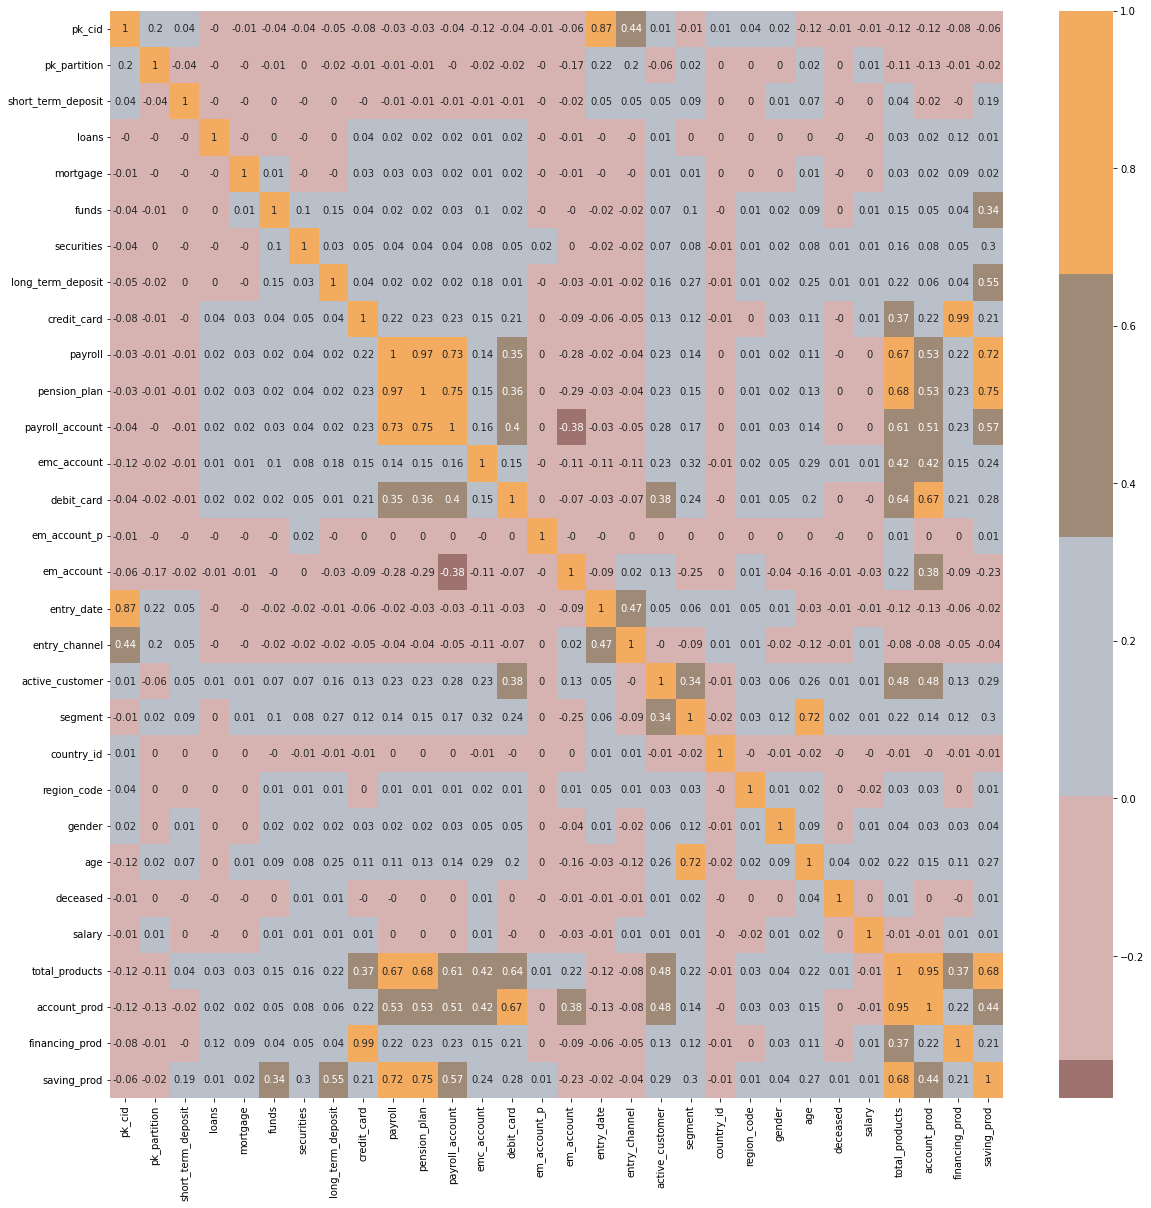

In [41]:
corrmat = df.corr().round(2)
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

##### **Studying variance**

We create a function where we enter the df and the threshold. It tells us which columns have less variance than that threshold, and therefore, they should be eliminated.  

With a variance less than 0.005 we have that the columns that must be eliminated are:  

**country_id, deceased, em_account_p, funds, loans, mortgage, securities, short_term_deposit**


In [40]:
def remove_low_variance_cols(df, threshold):

    # Select datetime columns
    datetime_columns = df.select_dtypes(include=['datetime64']).columns

    # Calculate the variance of numeric columns
    numeric_columns = df.select_dtypes(include=['int8', 'int32', 'int64', 'float64']).columns
    variance = df[numeric_columns].var()

    # Filter columns with variance less than or equal to the threshold and not datetime columns
    columns_to_remove = variance[variance <= threshold].index.difference(datetime_columns)

    # Remove the columns from the dataframe
    print(f'The following columns should be remove due a low variance: {columns_to_remove}')

    return 


In [41]:
remove_low_variance_cols(df, 0.005)

The following columns should be remove due a low variance: Index(['country_id', 'deceased', 'em_account_p', 'funds', 'loans', 'mortgage',
       'securities', 'short_term_deposit'],
      dtype='object')


##### **Conclusion**

After the correlation and variance study, we have the following variables that must be eliminated:  
 
**credit_card**, **payroll**, **country_id, deceased, em_account_p, funds, loans, mortgage, securities, short_term_deposit**

We can classify the features that we are going to eliminate as:   

* 8 product features: credit_card, payroll, em_account_p, funds, loans, mortgage, securities, short_term_deposit  
* 2 social features: country_id, deceased  




However, **it will not be now when we eliminate these features**. In the next section, Segmentation, we will need these features to create new ones. After that step we will proceed with the final elimination of this feature.   
Finally, we save the df in a csv file for the next step.

In [43]:
df.to_csv('data2_easymoney.csv', index = False)